# Seattle Burke Gilman Trail Dataset

This dataset contains hourly level pedestrian and bicycle counts at the Burke Gilman Trail in Seattle. 
There are a total of 4 series in the dataset: 2 bicycle count series (north-bound and south-bound) and 2 pedestrian count series. The data is filtered to cover the date range from 1/1/2017 to 7/31/2017. This dataset is useful for timeseries analysis involving short-term seasonalities, especially intra-day (hour-of-the-day) and intra-week (day-of-the-week) seasonalities. 

The dataset contains some extreme outliers, presumably due to one-off special events at the trail locations. 

In [312]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [313]:
dataset_name = "seattle_burke_gilman_trail"

In [341]:
input_fname = "Burke_Gilman_Trail_north_of_NE_70th_St_Bicycle_and_Pedestrian_Counter_20231228.csv"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [342]:
data = pd.read_csv(input_fname)
data.head()

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,01/01/2019 12:00:00 AM,0.0,0.0,0.0,0.0,0.0
1,01/01/2019 01:00:00 AM,2.0,1.0,0.0,1.0,0.0
2,01/01/2019 02:00:00 AM,1.0,0.0,0.0,0.0,1.0
3,01/01/2019 03:00:00 AM,0.0,0.0,0.0,0.0,0.0
4,01/01/2019 04:00:00 AM,1.0,0.0,0.0,1.0,0.0


# Prepare Data

# Drop the Total Column

We will drop "BGT North of NE 70th Total". It's the sum of the two bike and two ped trails

In [343]:
del data['BGT North of NE 70th Total']

## Rename Date to Datetime

In [344]:
data.rename(columns={"Date": "Datetime"}, inplace=True)
data.head()

,Datetime,Ped South,Ped North,Bike North,Bike South
0,01/01/2019 12:00:00 AM,0.0,0.0,0.0,0.0
1,01/01/2019 01:00:00 AM,1.0,0.0,1.0,0.0
2,01/01/2019 02:00:00 AM,0.0,0.0,0.0,1.0
3,01/01/2019 03:00:00 AM,0.0,0.0,0.0,0.0
4,01/01/2019 04:00:00 AM,0.0,0.0,1.0,0.0


## Format the Datetime Column 

In [345]:
# Convert the 'Date' column to datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%m/%d/%Y %I:%M:%S %p')
data.head()

,Datetime,Ped South,Ped North,Bike North,Bike South
0,2019-01-01 00:00:00,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,1.0,0.0,1.0,0.0
2,2019-01-01 02:00:00,0.0,0.0,0.0,1.0
3,2019-01-01 03:00:00,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00,0.0,0.0,1.0,0.0


## Sort DataFrame

In [346]:
data.sort_values(by=['Datetime'], inplace=True)

# Filter Date to 7 months

In [347]:
from datetime import datetime
start_datetime = datetime.strptime("2017-01-01 00-00-00", '%Y-%m-%d %H-%M-%S')
end_datetime = datetime.strptime("2017-07-31 23-59-59", '%Y-%m-%d %H-%M-%S')

data = data[(data["Datetime"]>=start_datetime) & (data["Datetime"]<=end_datetime)]

In [350]:
data.shape

(5088, 5)

## Fill Nans with Forward Fill

In [352]:
data.ffill(inplace=True)

## Unpivot the Trails

In [353]:
# Unpivot the data to have a long format for the trails.
data = data.melt(id_vars=['Datetime'], var_name='Trail', value_name='Count')

# Display the first few rows of the unpivoted dataset
data.head()

,Datetime,Trail,Count
0,2017-01-01 00:00:00,Ped South,0.0
1,2017-01-01 01:00:00,Ped South,0.0
2,2017-01-01 02:00:00,Ped South,1.0
3,2017-01-01 03:00:00,Ped South,0.0
4,2017-01-01 04:00:00,Ped South,0.0


In [354]:
data["Trail"].unique()

array(['Ped South', 'Ped North', 'Bike North', 'Bike South'], dtype=object)

# Add Static Variable Indicating Bike vs Ped

In [355]:
# Set to 1 for Bike trails
trail_type_map = {
    "Bike North": 1,
    "Bike South": 1,
    "Ped North": 0,
    "Ped South": 0,
}

data["Is_Bike_Trail"] = data["Trail"].map(trail_type_map)
data["Is_Ped_Trail"] = 1 - data["Is_Bike_Trail"]

data[['Trail', 'Is_Bike_Trail', 'Is_Ped_Trail']].drop_duplicates()

,Trail,Is_Bike_Trail,Is_Ped_Trail
0,Ped South,0,1
5088,Ped North,0,1
10176,Bike North,1,0
15264,Bike South,1,0


In [356]:
# for direction
trail_direction_map = {
    "Bike North": 1,
    "Bike South": 0,
    "Ped North": 1,
    "Ped South": 0,
}

data["Is_North_Trail"] = data["Trail"].map(trail_direction_map)
data["Is_South_Trail"] = 1 - data["Is_North_Trail"]

data[['Trail', 'Is_Bike_Trail', 'Is_Ped_Trail', 'Is_North_Trail', 'Is_South_Trail']].drop_duplicates()

,Trail,Is_Bike_Trail,Is_Ped_Trail,Is_North_Trail,Is_South_Trail
0,Ped South,0,1,0,1
5088,Ped North,0,1,1,0
10176,Bike North,1,0,1,0
15264,Bike South,1,0,0,1


In [357]:
data.shape

(20352, 7)

In [358]:
series_col = "Trail"
epoch_col = 'Datetime'
time_col = 'Datetime'
value_col = 'Count'
exog_cols=['Is_Bike_Trail', 'Is_Ped_Trail', 'Is_North_Trail', 'Is_South_Trail']

# Visualize

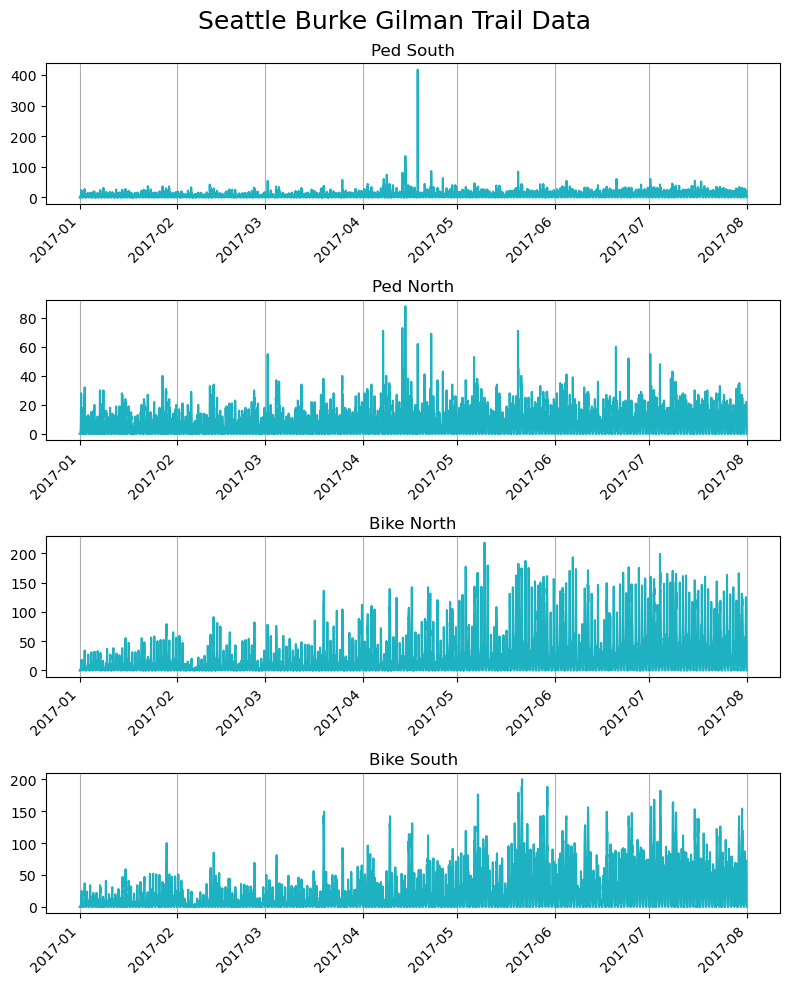

In [359]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='Datetime',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="Seattle Burke Gilman Trail Data"
)  


# Save Data

In [360]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols
    
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False)

In [361]:
data[all_cols].head()

,Trail,Datetime,Count,Is_Bike_Trail,Is_Ped_Trail,Is_North_Trail,Is_South_Trail
10176,Bike North,2017-01-01 00:00:00,0.0,1,0,1,0
10177,Bike North,2017-01-01 01:00:00,1.0,1,0,1,0
10178,Bike North,2017-01-01 02:00:00,0.0,1,0,1,0
10179,Bike North,2017-01-01 03:00:00,0.0,1,0,1,0
10180,Bike North,2017-01-01 04:00:00,0.0,1,0,1,0
